# Optimal UTXO size for difficulty and static reward

Quickly find the optimal Peercoin UTXO size for a given difficulty and static reward. Parameters can be adjusted for the displayed chart.

This uses daily probabilities as an approximation for per-second probabilities. It also assumes minting occurs continuously.

Determines the probability distribution for mints across multiple days and then finds a geometric average reward weighted by these probabilities.

Produced by MattLM with credit to Nagalim for ideas and alternative solutions.

Tips are welcome: PTuwboaoow7XF7Vrr68oremimo9wgrvxQ6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.0, 5.0]

## Parameters

In [2]:
MAX_DAYS = 365*2
MIN_PROB_DAYS=30
RAMP_UP = 60
RELATIVE_REWARD = 0.03

In [3]:
DIFF = 17.40
STATIC_REWARD = 1.34
EXAMPLE_SIZE = 100

# Recommended to keep False.
# This compounds the return of a single-output.
# This under-estimates returns for a wallet with many small utxos as
# the slow-compounding effects are removed when there are many outputs.
GEOMETRIC=False

## Helpful constants

In [4]:
SECDAY=60*60*24
DAYYEAR=(365*33+8)/33
# Offset days by 0.5 to assume mint occurs somewhere in middle of day
DAYS = [MIN_PROB_DAYS+x+0.5 for x in range(MAX_DAYS)]
NO_MINT_DAY = MAX_DAYS+MIN_PROB_DAYS
DAYS_WITH_NO_MINT = DAYS + [NO_MINT_DAY]

## Calculate daily probability distribution

Includes the rampup

In [5]:
# 60.5/(RAMP_UP+0.5) normalises so that the end probability is always the same
# Offset by 0.5 to assume middle of day
probSecs = np.array([2**224 * (min(x, RAMP_UP)+0.5) * (60.5/(RAMP_UP+0.5)) / (2**256) for x in range(MAX_DAYS)])

def generateDailyProbs(outValue, diff):
    
    adj = outValue / diff

    # Independent probabilities
    failDayProbs = (1 - probSecs*adj)**SECDAY
    mintDayProbs = 1 - failDayProbs

    # Actual probability of mint on day assuming no mints before
    cumFail = failDayProbs.cumprod()
    # Prob of fail up-to now
    cumPrevFail = np.insert(cumFail, 0, 1)[:MAX_DAYS]
    # Prob of fail up-to now and success now gives chance of mint on this day
    # Add probabilty of final day to represent no successful mints
    return np.append(cumPrevFail*mintDayProbs, cumFail[-1])
        

In [6]:
dayProbs = generateDailyProbs(EXAMPLE_SIZE, DIFF)

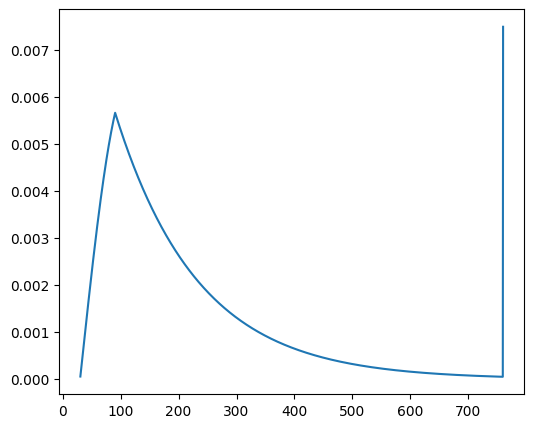

In [7]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs)
plt.show()

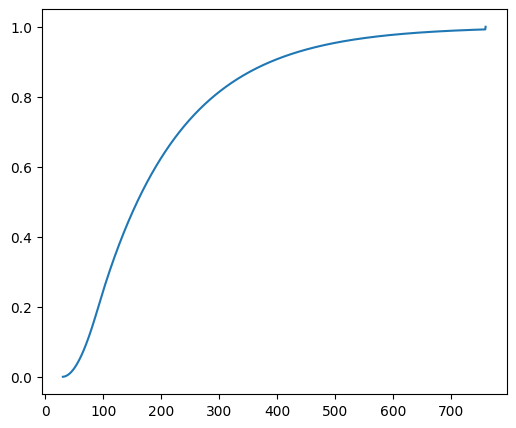

In [8]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs.cumsum())
plt.show()

In [9]:
# Should add up to 1
dayProbs.sum()

0.9999999999999999

## Calculate Geometric average of rewards weighted by probabilities

In [10]:
def dailyRewards(outValue, staticReward):
    mintRewards = np.fromiter((outValue*RELATIVE_REWARD*min(365, x)/DAYYEAR + staticReward for x in DAYS), dtype=float)
    includingFailed = np.append(mintRewards, 0)
    return includingFailed

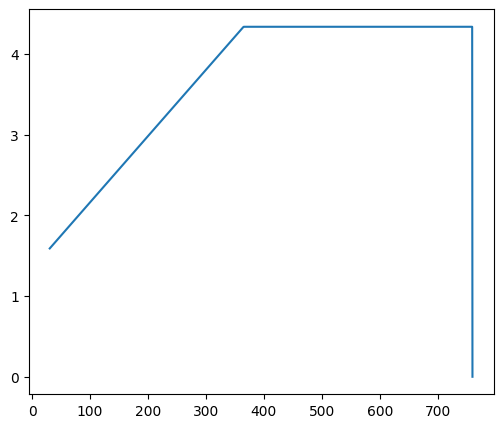

In [11]:
rewards = dailyRewards(EXAMPLE_SIZE, STATIC_REWARD)
plt.plot(DAYS_WITH_NO_MINT, rewards)
plt.show()

In [12]:
def averageReward(outValue, diff, staticReward, geometric=GEOMETRIC):
    probs = generateDailyProbs(outValue, diff)
    rewards = dailyRewards(outValue, staticReward)
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()

    if geometric:
        returns = 1+rewards/outValue
        weightedReturn = (returns**probs).prod()
        return (weightedReturn**(DAYYEAR/weightedTime) - 1) * 100

    # Arithmetic
    returns = rewards/outValue
    weightedReturn = (returns*probs).sum()
    return (weightedReturn*(DAYYEAR/weightedTime)) * 100

In [13]:
averageReward(EXAMPLE_SIZE, DIFF, STATIC_REWARD)

5.1374191261106885

## Plot UTXO sizes

In [49]:
sizes = [10**(x/125) for x in range(501)]

In [50]:
rewardForSizes = np.fromiter((averageReward(x, DIFF, STATIC_REWARD) for x in sizes), dtype=float)

In [16]:
def addFigText(optimal):
    plt.figtext(0.5, -0.03, f"Additional parameters: percentage reward={RELATIVE_REWARD*100}%, min days={MIN_PROB_DAYS}, ramp days={RAMP_UP}, max days={MAX_DAYS}, geometric={GEOMETRIC}", ha="center", fontsize=10)
    plt.figtext(0.5, -0.08, f"Optimal UTXO Size: {optimal:.6f} PPC", ha="center", fontsize=10)

In [17]:
def plotResults(results, yLabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, results)
    ax.set_xlabel("UTXO Size")
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    addFigText(sizes[results.argmax()])
    plt.xscale("log")
    plt.grid(which="both")
    plt.show()

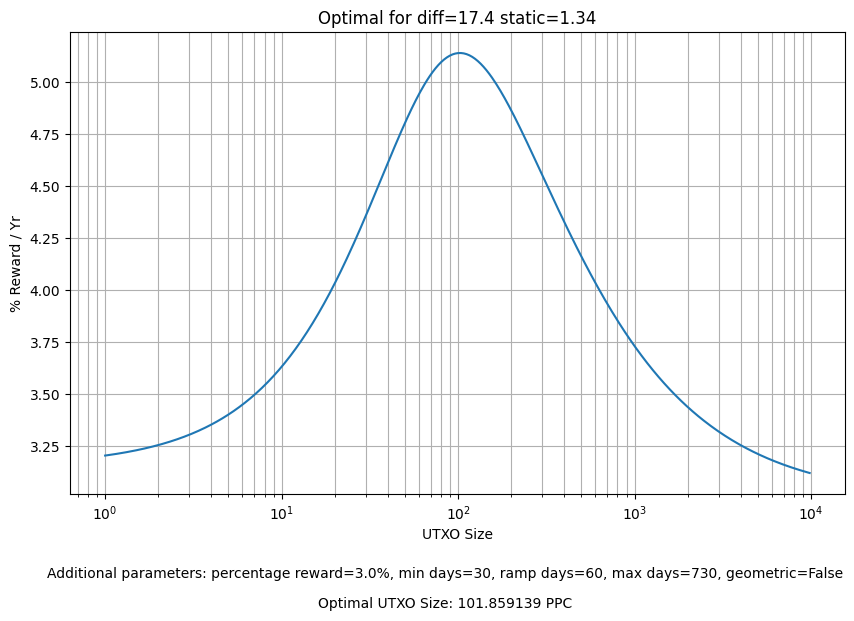

In [18]:
plotResults(rewardForSizes, "% Reward / Yr", f"Optimal for diff={DIFF} static={STATIC_REWARD}")

## Number of Mints

In [19]:
def averageMints(outValue, diff):
    probs = generateDailyProbs(outValue, diff)
    probFail = probs[-1]
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    return (1-probFail)/weightedTime/outValue*365

In [20]:
mintsForSizes = np.fromiter((averageMints(x, DIFF) for x in sizes), dtype=float)

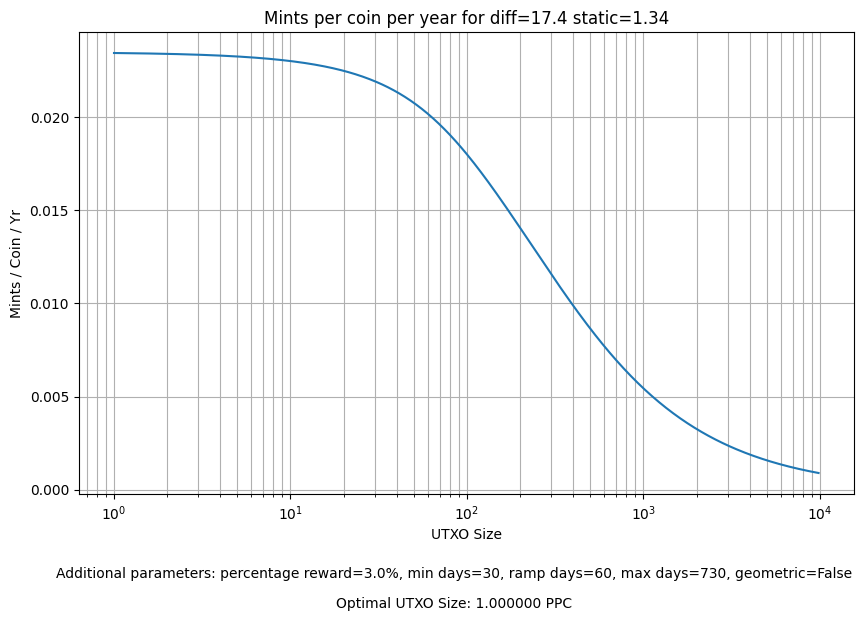

In [21]:
plotResults(mintsForSizes, "Mints / Coin / Yr", f"Mints per coin per year for diff={DIFF} static={STATIC_REWARD}")

## Combined Chart

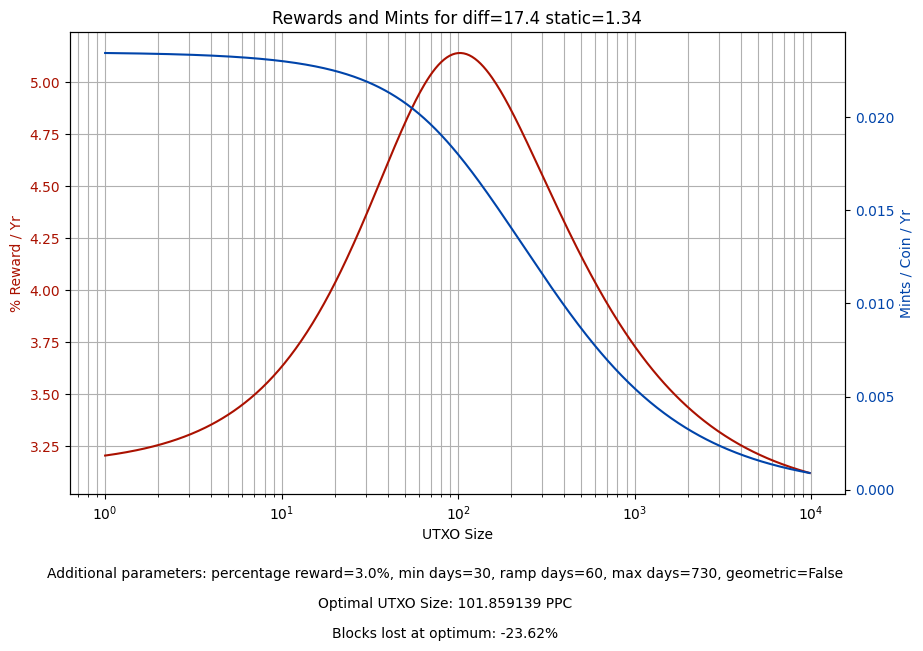

In [22]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Rewards and Mints for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")

colour = "#A10"
rewardAx.plot(sizes, rewardForSizes, color=colour)
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

mintsAx = rewardAx.twinx()
colour = "#04A"
mintsAx.plot(sizes, mintsForSizes, color=colour)
mintsAx.tick_params(axis ='y', labelcolor=colour) 
mintsAx.set_ylabel("Mints / Coin / Yr", color=colour)

addFigText(sizes[rewardForSizes.argmax()])

blockLoss = (1 - mintsForSizes[rewardForSizes.argmax()] / mintsForSizes.max())*100
plt.figtext(0.5, -0.13, f"Blocks lost at optimum: -{blockLoss:.2f}%", ha="center", fontsize=10)

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()

## Optimal UTXO Size

In [23]:
# UTXO Size
maxI = rewardForSizes.argmax()
sizes[maxI]

101.85913880541169

In [24]:
# Reward
maxReward = rewardForSizes.max()
maxReward

5.1378038285584635

In [25]:
def findWithinTolerance(it, tolerance):
    for i in it:
        if (maxReward - rewardForSizes[i] > tolerance):
            return sizes[i+1]

In [26]:
# -10bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.1)

71.77942912713618

In [27]:
# -10bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.1)

155.59656316050751

In [28]:
# -20bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.2)

60.81350012787179

In [29]:
# -20bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.2)

183.65383433483456

## Multi-output Simulation

Since the geometric simulation looks at a single output in isolation, a wallet containing many smaller outputs may produce a different outcome.

In [57]:
import random, math

In [69]:
def randomDaysToMint(size):

    adj = size / DIFF
    daysToMint=MIN_PROB_DAYS+0.5
    dayProbs = 1 - (1 - probSecs[:RAMP_UP+1]*adj)**SECDAY

    for x in range(RAMP_UP):
        if random.random()<dayProbs[x]:
            return daysToMint
        daysToMint+=1

    days = daysToMint+np.random.geometric(dayProbs[-1])
    return days if days < NO_MINT_DAY else NO_MINT_DAY

def calcReward(size, daysToMint):
    return 0 if daysToMint == NO_MINT_DAY else size*RELATIVE_REWARD*min(365, daysToMint)/DAYYEAR + STATIC_REWARD

def multiSim(size, n, sims=100000):

    # Split if over size*2^0.5
    maxSize = size*2**0.5
    
    startBalance = size*n
    simDay = 0

    mintDayIndices = np.random.choice(MAX_DAYS+1, size=n, p=generateDailyProbs(size, DIFF))
    nextMintDays = np.take(DAYS_WITH_NO_MINT, mintDayIndices)
    nextMintRewards = np.take(dailyRewards(size, STATIC_REWARD), mintDayIndices)
    outBalances = np.full(n, size, dtype=float)

    for i in range(sims):
        
        simDay = nextMintDays.min()
        index = nextMintDays.argmin()

        newBalance = outBalances[index] + nextMintRewards[index]

        # Split?
        if newBalance > maxSize:
            newBalance /= 2

            # Add new split utxo
            daysToMint = randomDaysToMint(newBalance)
            reward = calcReward(newBalance, daysToMint)
            nextMintDays = np.append(nextMintDays, simDay + daysToMint)
            nextMintRewards = np.append(nextMintRewards, reward)
            outBalances = np.append(outBalances, newBalance)

        # Update current utxo
        daysToMint = randomDaysToMint(newBalance)
        reward = calcReward(newBalance, daysToMint)
        nextMintDays[index] = simDay + daysToMint
        nextMintRewards[index] = reward
        outBalances[index] = newBalance;            
            
    endBalance = outBalances.sum()
    return ((endBalance/startBalance)**(DAYYEAR/nextMintDays.min())-1)*100

In [70]:
def simAndPrint(size, n):
    size = math.floor(size*1000000)/1000000
    print(f"{size}*{n}")
    return multiSim(size, n)

In [71]:
simSizes = [10**(x/7) for x in range(29)]
simulatedReward = np.fromiter((simAndPrint(x, int(10000//x)) for x in simSizes), dtype=float)

1.0*10000
1.389495*7196
1.930697*5179
2.682695*3727
3.727593*2682
5.179474*1930
7.196856*1389
10.0*1000
13.894954*719
19.306977*517
26.826957*372
37.275937*268
51.794746*193
71.968567*138
100.0*100
138.949549*71
193.069772*51
268.269579*37
372.759372*26
517.947467*19
719.685673*13
1000.0*10
1389.495494*7
1930.697728*5
2682.695795*3
3727.59372*2
5179.474679*1
7196.85673*1
10000.0*1


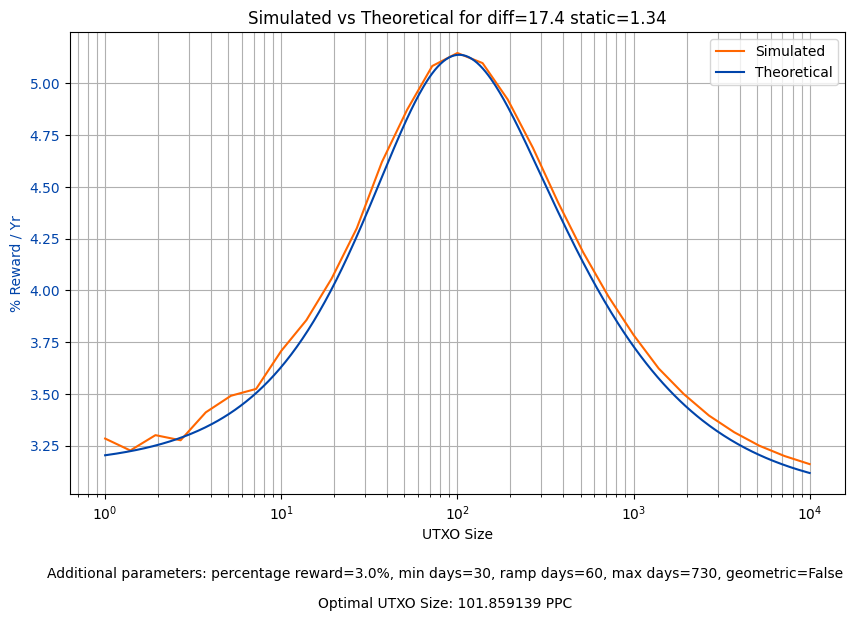

In [72]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Simulated vs Theoretical for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

p1, = rewardAx.plot(simSizes, simulatedReward, color="#F60", label="Simulated")
p2, = rewardAx.plot(sizes, rewardForSizes, color="#04A", label="Theoretical")
rewardAx.legend(handles=[p1, p2])

addFigText(sizes[rewardForSizes.argmax()])

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()